<a href="https://colab.research.google.com/github/berkyyd/Projects/blob/main/netflix_uyg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Veri İşleme
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Ağ Analizi (Yönetmen-Oyuncu İlişkileri İçin)
import networkx as nx

# Makine Öğrenmesi ve Modelleme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Değerlendirme
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

# Uyarıları Kapatma
import warnings
warnings.filterwarnings("ignore")

# Ekstra Araçlar
from collections import Counter

In [63]:
def load():
  df = pd.read_csv("netflix_data.csv")
  return df

df = load()
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,duration,description,genre
0,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,93,After a devastating earthquake hits Mexico Cit...,Dramas
1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,78,"When an army recruit is found dead, his fellow...",Horror Movies
2,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,80,"In a postapocalyptic world, rag-doll robots hi...",Action
3,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,123,A brilliant group of students become card-coun...,Dramas
4,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,1,A genetics professor experiments with a treatm...,International TV


Kategorik ve Numerik Sütunlar

In [21]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 4812
Variables: 11
cat_cols: 1
num_cols: 2
cat_but_car: 8
num_but_cat: 0


Aykırı Veri

In [22]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

check_outlier(df, num_cols)

True

In [64]:
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
  replace_with_thresholds(df, col)

check_outlier(df, num_cols)

False

Eksik Veri

In [24]:
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Örnek olarak Netflix veri setinin sadece 'description' sütununu alalım
descriptions = df['description'].fillna('')  # Eksik değerleri boş string yapıyoruz

# TF-IDF vektörleştirici oluştur
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # En sık geçen 500 kelimeyi alalım

# Metinleri vektör haline getir
tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)

# DataFrame formatına çevir
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Eski description sütununu kaldır ve TF-IDF sonuçlarını df'e ekle
df = df.drop('description', axis=1)
df = pd.concat([df, tfidf_df], axis=1)

# İlk 5 satıra bakalım
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,duration,genre,...,where,while,who,wife,with,woman,world,year,years,young
0,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016.0,93,Dramas,...,0.0,0.379435,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011.0,78,Horror Movies,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009.0,80,Action,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.406291,0.0,0.0,0.0
3,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008.0,123,Dramas,...,0.0,0.000000,0.0,0.0,0.264803,0.0,0.000000,0.0,0.0,0.0
4,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016.0,1,International TV,...,0.0,0.000000,0.0,0.0,0.375751,0.0,0.000000,0.0,0.0,0.0


In [26]:
df.shape

(4812, 110)

In [27]:
df['director'].value_counts()

,count
director,
"Raúl Campos, Jan Suter",18
Marcus Raboy,15
Jay Karas,14
Cathy Garcia-Molina,13
Martin Scorsese,12
...,...
"Robert Osman, Nathanael Wiseman",1
Ilya Naishuller,1
Paresh Mokashi,1


In [28]:
df['country'].value_counts()

,count
country,
United States,1886
India,864
United Kingdom,311
Canada,155
France,133
...,...
Venezuela,1
Zimbabwe,1
Namibia,1


In [66]:
# Rare Encoding Fonksiyonu - Sayısal eşik ile
def rare_encode(df, column, threshold=2):
    # Kategorik değişkenin sıklığını hesapla (cast sütunu için her bir oyuncu adı ayrı ayrı hesaplanır)
    if isinstance(df[column].iloc[0], list):  # Eğer veri listeyse (cast sütunu gibi)
        freq = df[column].explode().value_counts()
    else:
        freq = df[column].value_counts()

    # Eşik değerin altında olanları 'Other' olarak etiketle
    rare_categories = freq[freq < threshold].index
    # Eğer listeyse, her oyuncu için kontrol et
    if isinstance(df[column].iloc[0], list):
        df[column] = df[column].apply(lambda x: [y if y not in rare_categories else 'Other' for y in x])
    else:
        df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)
    return df

# Cast sütununu listeye dönüştürüp rare encoding uygulama
df['cast'] = df['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Rare Encoding'i director, country ve cast sütunlarına uygulama
df = rare_encode(df, 'director', threshold=2)
df = rare_encode(df, 'country', threshold=2)
df = rare_encode(df, 'cast', threshold=2)


In [30]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,duration,genre,...,where,while,who,wife,with,woman,world,year,years,young
0,s2,Movie,7:19,Other,"[Demián Bichir, Other, Other, Other, Other, Ca...",Mexico,"December 23, 2016",2016.0,93,Dramas,...,0.0,0.379435,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,s3,Movie,23:59,Other,"[Other, Other, Henley Hii, Other, Other, Other...",Singapore,"December 20, 2018",2011.0,78,Horror Movies,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,s4,Movie,9,Other,"[Elijah Wood, John C. Reilly, Other, Christoph...",United States,"November 16, 2017",2009.0,80,Action,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.406291,0.0,0.0,0.0
3,s5,Movie,21,Robert Luketic,"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",United States,"January 1, 2020",2008.0,123,Dramas,...,0.0,0.000000,0.0,0.0,0.264803,0.0,0.000000,0.0,0.0,0.0
4,s6,TV Show,46,Other,"[Other, Other, Melis Birkan, Saygın Soysal, Ot...",Turkey,"July 1, 2017",2016.0,1,International TV,...,0.0,0.000000,0.0,0.0,0.375751,0.0,0.000000,0.0,0.0,0.0


In [68]:
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')  # Tarihi datetime formatına çevir
df['year_added'] = df['date_added'].dt.year  # Yalnızca yılı al
df = df.drop('date_added', axis=1)  # Orijinal sütunu sil

In [69]:
df = df.drop(['show_id', 'title'], axis=1)

In [45]:
df.shape

(4812, 106)

In [70]:
df.head()

,type,director,cast,country,release_year,duration,genre,about,after,against,...,while,who,wife,with,woman,world,year,years,young,year_added
0,Movie,Other,"[Demián Bichir, Other, Other, Other, Other, Ca...",Mexico,2016.0,93,Dramas,0.0,0.281211,0.0,...,0.379435,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2016.0
1,Movie,Other,"[Other, Other, Henley Hii, Other, Other, Other...",Singapore,2011.0,78,Horror Movies,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2018.0
2,Movie,Other,"[Elijah Wood, John C. Reilly, Other, Christoph...",United States,2009.0,80,Action,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.406291,0.0,0.0,0.0,2017.0
3,Movie,Robert Luketic,"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",United States,2008.0,123,Dramas,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.264803,0.0,0.000000,0.0,0.0,0.0,2020.0
4,TV Show,Other,"[Other, Other, Melis Birkan, Saygın Soysal, Ot...",Turkey,2016.0,1,International TV,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.375751,0.0,0.000000,0.0,0.0,0.0,2017.0


In [71]:
# Tüm oyuncu isimlerini birleştiriyoruz
all_casts = [item for sublist in df['cast'] for item in sublist]

# LabelEncoder uyguluyoruz
le = LabelEncoder()
le.fit(all_casts)

# Cast sütununda her oyuncuya etiket atıyoruz
df['cast'] = df['cast'].apply(lambda x: le.transform(x))


In [72]:
# Director ve country sütunlarını sayısal hale getirme
df['director'] = le.fit_transform(df['director'])
df['country'] = le.fit_transform(df['country'])
df['type'] = le.fit_transform(df['type'])


In [76]:
df['cast_encoded'] = df['cast'].apply(lambda x: [int(i) for i in x])  # listeyi sayısal hale getiriyoruz

In [78]:
df.drop('cast', axis=1, inplace=True)

In [79]:
df.head()

,type,director,country,release_year,duration,genre,about,after,against,all,...,who,wife,with,woman,world,year,years,young,year_added,cast_encoded
0,0,418,32,2016.0,93,Dramas,0.0,0.281211,0.0,0.409317,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2016.0,"[1447, 4352, 4352, 4352, 4352, 939]"
1,0,418,47,2011.0,78,Horror Movies,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2018.0,"[4352, 4352, 2180, 4352, 4352, 4352, 3684, 554..."
2,0,418,58,2009.0,80,Action,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.406291,0.0,0.0,0.0,2017.0,"[1648, 2719, 4352, 1139, 1234, 3710, 1896, 435..."
3,0,488,58,2008.0,123,Dramas,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.264803,0.0,0.000000,0.0,0.0,0.0,2020.0,"[2651, 3160, 3016, 15, 3412, 4352, 3323, 2343,..."
4,1,418,55,2016.0,1,International TV,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.375751,0.0,0.000000,0.0,0.0,0.0,2017.0,"[4352, 4352, 3837, 5156, 4352, 4352, 4352, 435..."


Görselleştirmeler

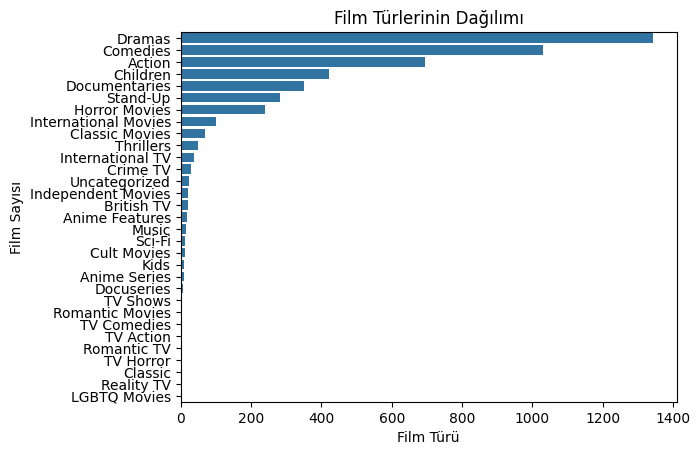

In [73]:
# Film türlerinin dağılımını görselleştiriyoruz
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index)
plt.title('Film Türlerinin Dağılımı')
plt.xlabel('Film Türü')
plt.ylabel('Film Sayısı')
plt.show()


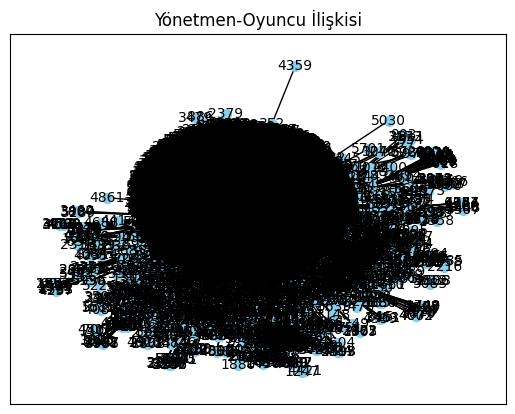

In [61]:
# Yönetmen-oyuncu ilişkilerini analiz edelim
G = nx.Graph()

# Her bir yönetmen-oyuncu ilişkisini ağda bir bağlantı olarak ekliyoruz
for idx, row in df.iterrows():
    director = row['director']
    for cast_member in row['cast']:
        if director and cast_member:
            G.add_edge(director, cast_member)

# Ağ grafiğini çiziyoruz
nx.draw_networkx(G, node_size=50, font_size=10, with_labels=True, node_color='skyblue')
plt.title('Yönetmen-Oyuncu İlişkisi')
plt.show()


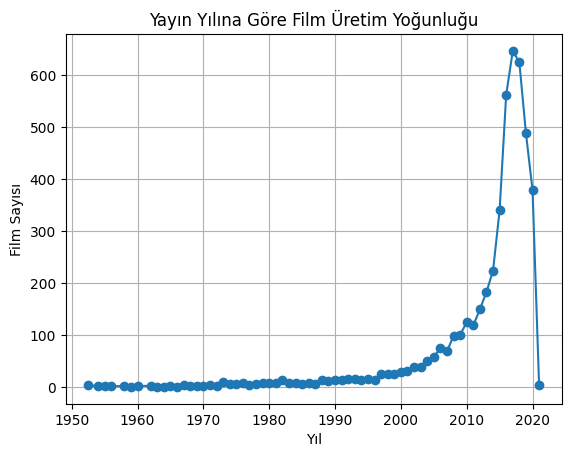

In [74]:
# Yayın yılına göre film üretim yoğunluğunu görselleştiriyoruz
df['release_year'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Yayın Yılına Göre Film Üretim Yoğunluğu')
plt.xlabel('Yıl')
plt.ylabel('Film Sayısı')
plt.grid(True)
plt.show()


Modelleme

In [92]:
# Bağımsız değişkenler (X) ve bağımlı değişken (y)
X = df.drop(columns=['genre', 'cast_encoded'])  # genre dışındaki tüm sütunlar
y = df['genre']  # genre sütunu hedef (target)

# Yalnızca bir filme sahip türler
genre_counts = y.value_counts()
genres_to_remove = genre_counts[genre_counts == 1].index

# Bu türlere sahip satırları kaldır
df = df[~y.isin(genres_to_remove)]
X = df.drop(columns=['genre', 'cast_encoded'])
y = df['genre']

# Kategorik sütunları sayısal hale getirelim
encoder = LabelEncoder()
y = encoder.fit_transform(y)  # genre'yi sayısal hale getirelim

# Eğitim ve test verisine ayıralım (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train Set: {X_train.shape}, Test Set: {X_test.shape}")

Train Set: (3842, 106), Test Set: (961, 106)


In [87]:
df.dropna(inplace=True)

In [93]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }

    results = {}

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        # Modeli eğit
        model.fit(X_train, y_train)

        # Tahmin yap
        y_pred = model.predict(X_test)

        # Performansı değerlendirelim
        accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True)

        # Sonuçları sakla
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision (Macro)': class_report['macro avg']['precision'],
            'Recall (Macro)': class_report['macro avg']['recall'],
            'F1-Score (Macro)': class_report['macro avg']['f1-score']
        }

    # Sonuçları döndürelim
    return results

# Modelleri değerlendirelim
results = evaluate_models(X_train, X_test, y_train, y_test)

# Sonuçları yazdıralım
for model_name, metrics in results.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...

Logistic Regression Performance:
Accuracy: 0.3330
Precision (Macro): 0.1153
Recall (Macro): 0.1361
F1-Score (Macro): 0.1096

Decision Tree Performance:
Accuracy: 0.3600
Precision (Macro): 0.2510
Recall (Macro): 0.2500
F1-Score (Macro): 0.2487

Random Forest Performance:
Accuracy: 0.4506
Precision (Macro): 0.2702
Recall (Macro): 0.2201
F1-Score (Macro): 0.2211

XGBoost Performance:
Accuracy: 0.4620
Precision (Macro): 0.3331
Recall (Macro): 0.2892
F1-Score (Macro): 0.3003


Hiperparametre Optimizasyonu

In [94]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import numpy as np

In [96]:
# Modeller ve hiperparametre aralıkları
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    #'XGBoost': XGBClassifier()
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Decision Tree': {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

def hyperparameter_optimization(X_train, y_train, X_test, y_test, models, param_grids):
    best_models = {}
    results = {}

    for model_name, model in models.items():
        print(f"Optimizing {model_name}...")

        # GridSearchCV or RandomizedSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name],
                                   scoring='accuracy', n_jobs=-1, cv=5)

        # Fit the grid search
        grid_search.fit(X_train, y_train)

        # Get the best model
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model

        # Predict and evaluate on the test set
        y_pred = best_model.predict(X_test)

        # Store the results
        results[model_name] = {
            'Best Parameters': grid_search.best_params_,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }

        print(f"{model_name} best score: {grid_search.best_score_}")
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    return best_models, results

# Modelleme için eğitim ve test verisini oluşturduktan sonra bu fonksiyonu kullanabilirsiniz
best_models, results = hyperparameter_optimization(X_train, y_train, X_test, y_test, models, param_grids)

# Sonuçları görmek için
for model_name, result in results.items():
    print(f"\n{model_name} Result:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Classification Report: \n{result['Classification Report']}")


Optimizing Logistic Regression...
Logistic Regression best score: 0.4120289472258344
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Optimizing Decision Tree...
Decision Tree best score: 0.3896385321846554
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Optimizing Random Forest...
Random Forest best score: 0.4552300065019506
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Logistic Regression Result:
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.4214360041623309
Classification Report: 
              precision    recall  f1-score   support

           0       0.35      0.06      0.11       139
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       1.00      0.25      0.40         4
           4       0.38      0.31  